# Solve GP regression by SDE 

In [ ]:
# Activate local environment, see `Project.toml`
import Pkg; Pkg.activate(".."); Pkg.instantiate();

In this notebook, we solve a GP regression problem by using "Stochastic Differential Equation" (SDE). This method is well described in the dissertation "Stochastic differential equation methods for spatio-temporal Gaussian process regression." by Arno Solin and "Sequential Inference for Latent Temporal Gaussian Process Models" by Jouni Hartikainen. The idea of the method is as follows.

Suppose a function $f(x)$ follows a zero-mean Gaussian Process
$$\begin{aligned}
f(x) \sim \mathcal{GP}(0, k(x,x')).
\end{aligned}$$

When the dimensionality of $x$ is 1, we can consider $f(x)$ as a stochastic process over time, i.e. $f(t)$. For a certain classses of covariance functions, $f(t)$ is a solution to an $m$-th order linear stochastic differential equation (SDE)
$$\begin{aligned}
a_0 f(t) + a_1 \frac{d f(t)}{dt} + \dots + a_m \frac{d^m f(t)}{dt^m} = w(t) 
\end{aligned}$$

where $w(t)$ is a zero-mean white noise process with spectral density $Q_c$. If we define a vector-valued function $\mathbf{f}(t) = (f(t),\, d/dt f(t),\dots,\, d^{m-1}/dt^{m-1}f(t))$, then we can rewrite the above SDE under the companion form

$$\begin{aligned}
\frac{d \mathbf{f}(t)}{dt} = \mathbf{F}\, \mathbf{f}(t) + \mathbf{L} w(t) \quad (1)
\end{aligned}$$

where $\mathbf{F}$ and $\mathbf{L}$ are defined based on the choice of covariance functions. 
From (1), we have the following state-space model:
$$\begin{aligned}
\mathbf{f}_k = \mathbf{A}_{k-1} \, \mathbf{f}_{k-1} + \mathbf{q}_{k-1}, \quad \mathbf{q}_{k-1} \sim \mathcal{N}(\mathbf{0}, \mathbf{Q}_{k-1}) \quad(2a) \\
y_k = \mathbf{H} \, \mathbf{f}(t_k) + \epsilon_k , \quad \epsilon_k \sim \mathcal{N}(0, \sigma^2_{noise}) \quad(2b). \\
\end{aligned}$$

where $\mathbf{A}_k = \exp{(\mathbf{F}\,\Delta t_k)}$, with $\Delta t_k = t_{k+1} - t_k$, is called the discrete-time state transition matrix, and $\mathbf{Q}_k$ the process noise covariance matrix. For the computation of $\mathbf{Q}_k$, we will come back later. According to Arno Solin and Jouni Hartikainen's dissertation, the GP regression problem amounts to the inference problem of the above state-space model, and this can be solved by RTS-smoothing. The state-space model starts from  the initial state $f_0 \sim \mathcal{N}(\mathbf{0},\, \mathbf{P}_0)$. For stationary covariance function, the SDE has a stationary state $f_\infty \sim \mathcal{N}(\mathbf{0},\, \mathbf{P}_\infty)$, where $\mathbf{P}_\infty$ is the solution to
$$\begin{aligned}
\frac{d\mathbf{P}_\infty}{dt} = \mathbf{F} \mathbf{P}_\infty + \mathbf{P}_\infty \mathbf{F}^T + \mathbf{L} \mathbf{Q}_c \mathbf{L}^T = 0 \quad (\mathrm{Lyapunov \, equation}).
\end{aligned}$$

With this stationary condition, the process noise covariance $\mathbf{Q}_k$ is computed as follows
$$\begin{aligned}
\mathbf{Q}_k = \mathbf{P}_\infty - \mathbf{A}_k \mathbf{P}_\infty \mathbf{A}_k^T 
\end{aligned}$$

For one-dimensional problem the SDE representation of the GP is defined by the matrices $\mathbf{F}, \, \mathbf{L}, \, \mathbf{Q}_c, \, \mathbf{P}_0$ and $\mathbf{H}$. Once we obtain all the matrices, we can do GP regression by implementing RTS-smoothing on the state-space model (2). In this notebook we will particularly use the Matern class of covariance functions for Gaussian Process.



In [15]:
using RxInfer, Random, Distributions, LinearAlgebra, Plots

## Create state space model for GP regression
Here we create a state-space model
$$\begin{aligned}
\mathbf{f}_k = \mathbf{A}_{k-1} \, \mathbf{f}_{k-1} + \mathbf{q}_{k-1}, \quad \mathbf{q}_{k-1} \sim \mathcal{N}(\mathbf{0}, \mathbf{Q}_{k-1}) \\
y_k = \mathbf{H} \, \mathbf{f}(t_k) + \epsilon_k , \quad \epsilon_k \sim \mathcal{N}(0, \sigma^2_{noise}), \\
\end{aligned}$$
where $y_k$ is the noisy observation of the function $f$ at time $t_k$, and $\sigma^2_{noise}$ is the noise variance and assumed to be known.

In [16]:
@model function gp_regression(n, P∞, A, Q, H, σ²_noise)
    f_0 ~ MvNormalMeanCovariance(zeros(length(H)), P∞)
    f = randomvar(n)
    y = datavar(Float64, n) where { allow_missing = true }
    
    f_prev = f_0

    for i=1:n
        f[i] ~ MvNormalMeanCovariance(A[i] * f_prev, Q[i])
        y[i] ~ NormalMeanVariance(dot(H , f[i]), σ²_noise)
        f_prev = f[i]
    end
    return f, y
end

Since we only observe the (noisy) function value at some time instances on the timeline, the data variable $y$ contains $\textit{missing}$ values and this requires us to add update rule for missing messages.

In [17]:
@rule MvNormalMeanCovariance(:μ, Marginalisation) (m_out::Missing, q_Σ::PointMass, ) = missing

@rule NormalMeanVariance(:μ, Marginalisation) (q_out::Missing, q_v::PointMass) = missing

@rule typeof(*)(:in, Marginalisation) (m_out::Missing, m_A::PointMass, meta::TinyCorrection) = missing

@rule typeof(dot)(:in2, Marginalisation) (m_out::Missing, m_in1::PointMass, meta::TinyCorrection) = missing

## Generate data

In [18]:
Random.seed!(10)
n = 100
σ²_noise = 0.04;
t = collect(range(-2, 2, length=n)); #timeline
f_true = sinc.(t); # true process
f_noisy = f_true + sqrt(σ²_noise)*randn(n); #noisy process

pos = sort(randperm(75)[1:2:75]); 
t_obser = t[pos]; # time where we observe data

y_data = Array{Union{Float64,Missing}}(missing, n)
for i in pos 
    y_data[i] = f_noisy[i]
end

θ = [1., 1.]; # store [l, σ²]
Δt = [t[1]]; # time difference
append!(Δt, t[2:end] - t[1:end-1]);

### Let's visualize our data

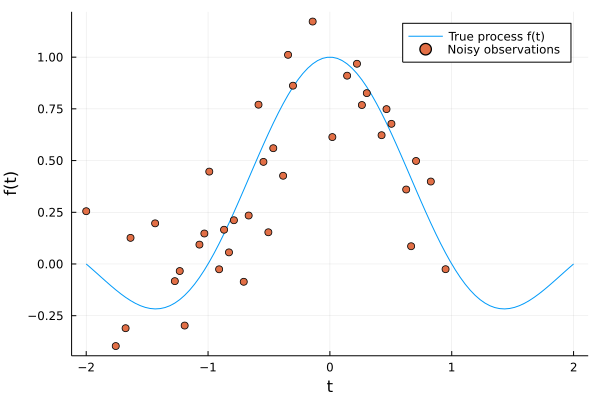

In [19]:
plot(t, f_true, label="True process f(t)")
scatter!(t_obser, y_data[pos], label = "Noisy observations")
xlabel!("t")
ylabel!("f(t)")

## Covariance function: Matern-3/2

The Matern is a stationary covariance function and defined as follows
$$\begin{aligned}
k(\tau) = \sigma^2 \frac{2^{1-\nu}}{\Gamma(\nu)} \left(\frac{\sqrt{2\nu}\tau}{l} \right)^\nu K_\nu\left(\frac{\sqrt{2\nu}\tau}{l} \right)
\end{aligned}$$
where 
$$\begin{aligned} \sigma^2: \text{the magnitude scale hyperparameter}\\
l: \text{the characteristic length-scale}\\
\nu: \text{the smoothness hyperparameter}\\
K_\nu(.): \text{the modified Bessel function of the second kind}.
\end{aligned}$$
When we say the Matern-3/2, we mean $\nu=3/2$. The matrices for the state space model are computed as follows
$$\begin{aligned}
\mathbf{F} = \begin{pmatrix}
0 & 1\\
-\lambda^2 & -2\lambda
\end{pmatrix} ,\quad \quad \mathbf{L} = \begin{pmatrix}
0 \\ 1
\end{pmatrix}, \quad \quad \mathbf{P}_\infty = \begin{pmatrix}
\sigma^2 & 0 \\ 0 & \lambda^2\sigma^2
\end{pmatrix} ,\quad \quad \mathbf{H} = \begin{pmatrix}
1 & 0
\end{pmatrix}, \quad \quad Q_c = 4\lambda^3\sigma^2
\end{aligned}$$ 
where $\lambda = \frac{\sqrt{3}}{l} $. From these matrices, we can define $\mathbf{A}_k$ and $\mathbf{Q}_k$.

In [20]:
λ = sqrt(3)/θ[1];
#### compute matrices for the state-space model ######
L = [0., 1.];
H = [1., 0.];
F = [0. 1.; -λ^2 -2λ]
P∞ = [θ[2] 0.; 0. (λ^2*θ[2]) ]
A = [exp(F * i) for i in Δt]; 
Q = [P∞ - i*P∞*i' for i in A];

In [21]:
result_32 = inference(
    model = gp_regression(n, P∞, A, Q, H, σ²_noise),
    data = (y = y_data,)
)

Inference results:
-----------------------------------------
f   = AbstractMvNormal[MvNormalWeightedMeanPrecision(
xi: [1.9358864892079541, -0.5582...
f_0 = MvNormalWeightedMeanPrecision(
xi: [-0.15600456698710335, 0.06323742274432151]
Λ...


## Covariance function: Matern-5/2

Now let's try the Matern-5/2 kernel. The matrices for the SDE representation of the Matern-5/2 are:

$$\begin{aligned}
\mathbf{F} = \begin{pmatrix}
0 & 1 & 0\\
0 & 0 & 1 \\
-\lambda^3 & -3\lambda^2 & -3\lambda
\end{pmatrix} ,\quad \quad \mathbf{L} = \begin{pmatrix}
0 \\ 0 \\ 1
\end{pmatrix}, \quad \quad \mathbf{H} = \begin{pmatrix}
1 & 0 & 0
\end{pmatrix}, \quad \quad Q_c = \frac{16}{3} \sigma^2 \lambda^5, 
\end{aligned}$$

where $\lambda = \sqrt{5} / l$. To find $\mathbf{P}_\infty$, we solve the Lyapunov equation

$$\begin{aligned}
\frac{d\mathbf{P}_\infty}{dt} = \mathbf{F} \mathbf{P}_\infty + \mathbf{P}_\infty \mathbf{F}^T + \mathbf{L} \mathbf{Q}_c \mathbf{L}^T = 0,
\end{aligned}$$

of which the solution is

$$\begin{aligned}
vec(\mathbf{P}_\infty) = (\mathbf{I} \otimes \mathbf{F} + \mathbf{F}\otimes\mathbf{I})^{-1}\, vec(-\mathbf{L}Q_c\mathbf{L}^T)
\end{aligned}$$

where $vec(.)$ is the vectorization operator and $\otimes$ denotes the Kronecker product. Now we can find $\mathbf{A}_k$ and $\mathbf{Q}_k$ 

$$\begin{aligned}
\mathbf{A}_k = \exp{(\mathbf{F}\Delta t_k)} 
\end{aligned}$$

$$\begin{aligned}
\mathbf{Q}_k = \mathbf{P}_\infty - \mathbf{A}_k \mathbf{P}_\infty \mathbf{A}_k^T  
\end{aligned}$$

In [22]:
λ = sqrt(5)/θ[1];
#### compute matrices for the state-space model ######
L = [0., 0., 1.];
H = [1., 0., 0.];
F = [0. 1. 0.; 0. 0. 1.;-λ^3 -3λ^2 -3λ]
Qc = 16/3 * θ[2] * λ^5;

I = diageye(3) ; 
vec_P = inv(kron(I,F) + kron(F,I)) * vec(-L * Qc * L'); 
P∞ = reshape(vec_P,3,3);
A = [exp(F * i) for i in Δt]; 
Q = [P∞ - i*P∞*i' for i in A];

In [23]:
result_52 = inference(
    model = gp_regression(n, P∞, A, Q, H, σ²_noise),
    data = (y = y_data,)
)

Inference results:
-----------------------------------------
f   = AbstractMvNormal[MvNormalWeightedMeanPrecision(
xi: [-3.110075631578919, -1.8282...
f_0 = MvNormalWeightedMeanPrecision(
xi: [0.3719880978328811, -0.21107990590357117, 0....


## Result

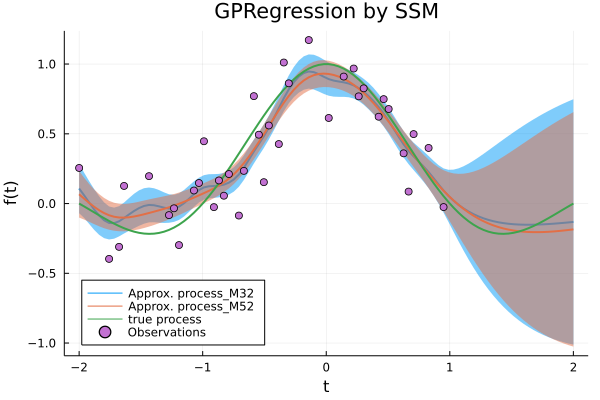

In [24]:
slicedim(dim) = (a) -> map(e -> e[dim], a)

plot(t, mean.(result_32.posteriors[:f]) |> slicedim(1), ribbon = var.(result_32.posteriors[:f]) |> slicedim(1) .|> sqrt, label ="Approx. process_M32", title = "Matern-3/2", legend =false, lw = 2)
plot!(t, mean.(result_52.posteriors[:f]) |> slicedim(1), ribbon = var.(result_52.posteriors[:f]) |> slicedim(1) .|> sqrt, label ="Approx. process_M52",legend = :bottomleft, title = "GPRegression by SSM", lw = 2)
plot!(t, f_true,label="true process", lw = 2)
scatter!(t_obser, f_noisy[pos], label="Observations")
xlabel!("t")
ylabel!("f(t)")


As we can see from the plot, both cases of Matern kernel provide good approximations (small variance) to the true process at the area with dense observations (namely from t = 0 to around 3.5), and when we move far away from this region the approximated processes become less accurate (larger variance). This result makes sense because GP regression exploits the correlation between observations to predict unobserved points, and the choice of covariance functions as well as their hyper-parameters might not be optimal. We can increase the accuracy of the approximated processes by simply adding more observations. This way of improvement does not trouble the state-space method much but it might cause computational problem for naive GP regression, because with N observations the complexity of naive GP regression scales with $N^3$ while the state-space method scales linearly with N.     